# 8.0.0 Evaluate Final Classifier Model

In [1]:
import pandas as pd
import numpy as np
import pickle
import yaml
import shap 
from pathlib import Path
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score
from src.utils import calculate_metrics, load_pickle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

/Users/mfrancys/.local/share/virtualenvs/credit-risk-machine-learning-pipeline-TF6eVTA0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_metrics_by(df, group_col, target):
    
    monthly_metrics = {}
  
    for month in list(df[group_col].unique()):

        df_filter = df[df[group_col]==month]
        
        y_holdout = df_filter[target]
        preds = df_filter['score']
        
        roc_auc = metrics.roc_auc_score(y_true=y_holdout, y_score=preds)
        pr = metrics.average_precision_score(y_true=y_holdout, y_score=preds)
        ks = ks_2samp(preds[y_holdout == 0], preds[y_holdout == 1])[0]

        metrics_dict = {
            'roc_auc_score': roc_auc,
            'pr_auc': pr,
            'ks': ks,
        }

        monthly_metrics[month] = metrics_dict

    return monthly_metrics

### 1. Data Preparation


In [3]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
numeric_features = config["filter_features"]["numerical"]

features = numeric_features
target = config["main"]["target"]
test_data_path = Path.cwd().parent / config["main"]["data_test_path"]

test_df = pd.read_pickle(test_data_path)

model_path = Path.cwd().parent / config["main"]["model_path"]
model = load_pickle(Path.cwd().parent / config["main"]["model_path"])

X_test, Y_test = test_df[features], test_df[target]

test_df["score"] = model.predict_proba(X_test)[:, 1]

In [4]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 5), (5, 10), (10, 20), (20, 30), (30, 300)])
test_df["credit_reports__loans_count_range"] = pd.cut(test_df["credit_reports__loans_count"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["credit_reports__loans_count_range"]).agg({"target": ["count", "sum", "mean"]})
_test_df

/var/folders/p2/fsndgvv13vgf1z1pgd3j7y400000gn/T/ipykernel_30704/1069862406.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _test_df = test_df.groupby(["credit_reports__loans_count_range"]).agg({"target": ["count", "sum", "mean"]})


target               
                                   count  sum      mean
credit_reports__loans_count_range                      
(-1, 0]                             1238  209  0.168821
(0, 5]                               268   38  0.141791
(5, 10]                              325   61  0.187692
(10, 20]                             588  123  0.209184
(20, 30]                             405   74  0.182716
(30, 300]                           1021  145  0.142018

In [5]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 5), (5, 300)])
test_df["credit_reports__loans_count_range_3_labels"] = pd.cut(test_df["credit_reports__loans_count"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["credit_reports__loans_count_range_3_labels"]).agg({"target": ["count", "sum", "mean"]})
_test_df

/var/folders/p2/fsndgvv13vgf1z1pgd3j7y400000gn/T/ipykernel_30704/1215341964.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _test_df = test_df.groupby(["credit_reports__loans_count_range_3_labels"]).agg({"target": ["count", "sum", "mean"]})


target               
                                            count  sum      mean
credit_reports__loans_count_range_3_labels                      
(-1, 0]                                      1238  209  0.168821
(0, 5]                                        268   38  0.141791
(5, 300]                                     2339  403  0.172296

In [6]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0, 20)])
test_df["previous_internal_apps__n_bnpl_approved_apps_range"] = pd.cut(test_df["previous_internal_apps__n_bnpl_approved_apps"], bins = bins, right = False, include_lowest=True)
_test_df = test_df.groupby(["previous_internal_apps__n_bnpl_approved_apps_range"]).agg({"target": ["count", "sum", "mean"]})
_test_df

/var/folders/p2/fsndgvv13vgf1z1pgd3j7y400000gn/T/ipykernel_30704/2657540764.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _test_df = test_df.groupby(["previous_internal_apps__n_bnpl_approved_apps_range"]).agg({"target": ["count", "sum", "mean"]})


target               
                                                    count  sum      mean
previous_internal_apps__n_bnpl_approved_apps_range                      
(-1, 0]                                              3307  587  0.177502
(0, 20]                                               538   63  0.117100

### 2. Model Results

{'roc_auc_score': 0.5634149512459371,
 'pr_auc': 0.1988542886713352,
 'ks': 0.10111713013121464}

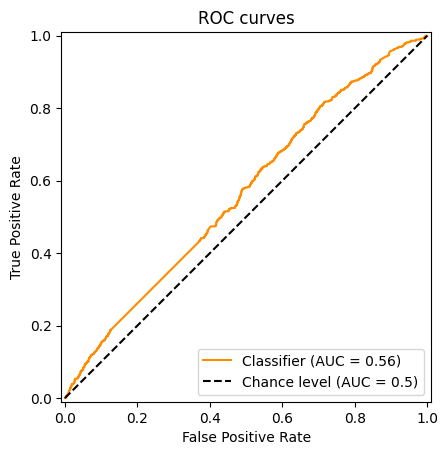

In [7]:
display = RocCurveDisplay.from_predictions(
    Y_test,
    test_df["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

calculate_metrics(Y_test, test_df["score"])

In [8]:
pd.DataFrame(calculate_metrics_by(test_df, 'loan_origination_datetime_month', target)).T.sort_index()

,roc_auc_score,pr_auc,ks
2023-03,0.560691,0.212087,0.100901
2023-04,0.566589,0.186332,0.121786


In [9]:
pd.DataFrame(calculate_metrics_by(test_df, "credit_reports__loans_count_range", target)).T.sort_index()

,roc_auc_score,pr_auc,ks
"(-1, 0]",0.501265,0.169333,0.019199
"(0, 5]",0.593478,0.238011,0.180778
"(5, 10]",0.580353,0.235799,0.173746
"(10, 20]",0.586957,0.255309,0.177288
"(20, 30]",0.611946,0.251436,0.212460
"(30, 300]",0.580287,0.173420,0.165627


In [10]:
pd.DataFrame(calculate_metrics_by(test_df, "credit_reports__loans_count_range_3_labels", target)).T.sort_index()

,roc_auc_score,pr_auc,ks
"(-1, 0]",0.501265,0.169333,0.019199
"(0, 5]",0.593478,0.238011,0.180778
"(5, 300]",0.595612,0.220181,0.153134


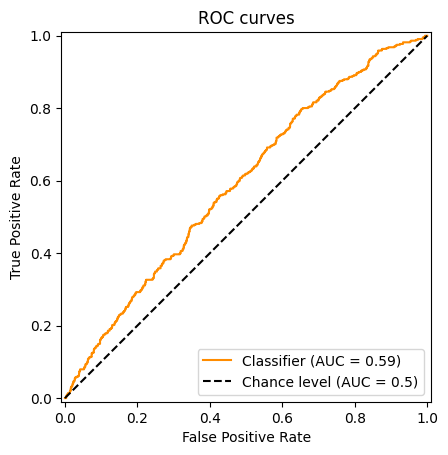

In [11]:
test_df_aux = test_df[test_df["credit_reports__loans_count"]>0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

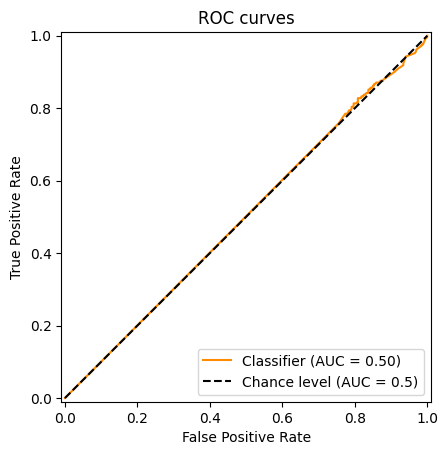

In [12]:
test_df_aux = test_df[test_df["credit_reports__loans_count"]==0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

In [13]:
pd.DataFrame(calculate_metrics_by(test_df, "previous_internal_apps__n_bnpl_approved_apps_range", target)).T.sort_index()

,roc_auc_score,pr_auc,ks
"(-1, 0]",0.541567,0.199781,0.066469
"(0, 20]",0.638129,0.190874,0.229908


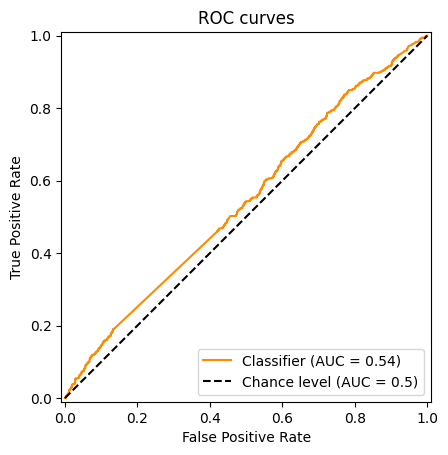

In [14]:
test_df_aux = test_df[test_df["previous_internal_apps__n_bnpl_approved_apps"]==0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

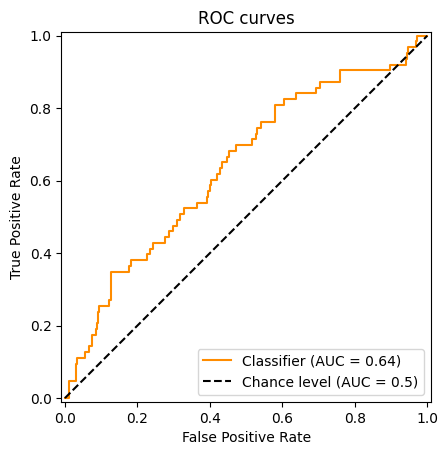

In [15]:
test_df_aux = test_df[test_df["previous_internal_apps__n_bnpl_approved_apps"]>0]
display = RocCurveDisplay.from_predictions(
    test_df_aux[target],
    test_df_aux["score"],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

### 2. Shap values 

#### Overall

(3845, 14)


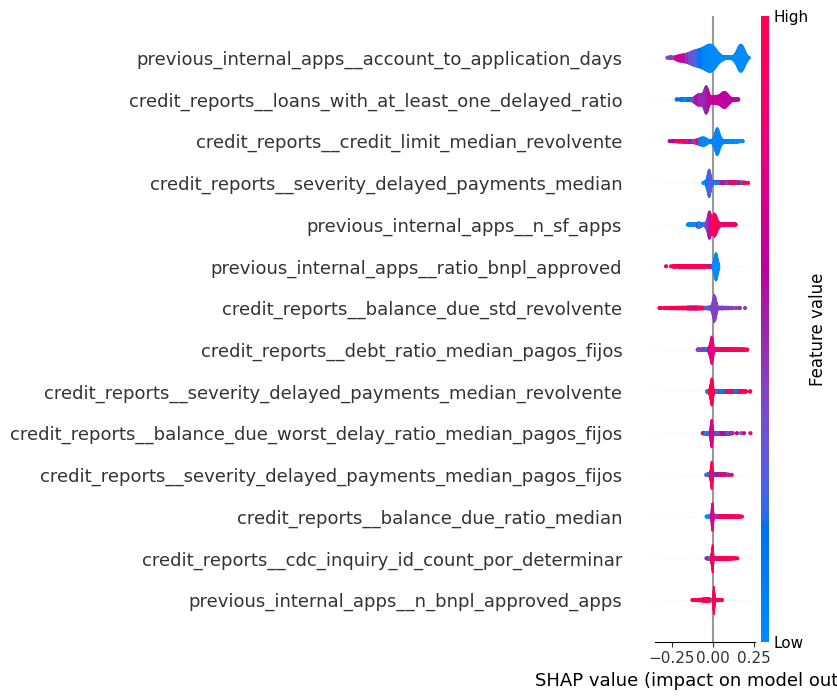

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.098605
10,credit_reports__loans_with_at_least_one_delaye...,0.061515
8,credit_reports__credit_limit_median_revolvente,0.053365
11,credit_reports__severity_delayed_payments_median,0.036258
2,previous_internal_apps__n_sf_apps,0.036006
3,previous_internal_apps__ratio_bnpl_approved,0.028631
5,credit_reports__balance_due_std_revolvente,0.023330
9,credit_reports__debt_ratio_median_pagos_fijos,0.020097
13,credit_reports__severity_delayed_payments_medi...,0.018294
6,credit_reports__balance_due_worst_delay_ratio_...,0.016788


In [16]:
df_test_filter = test_df
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)

#### Shap Values - New Customer

(1238, 14)


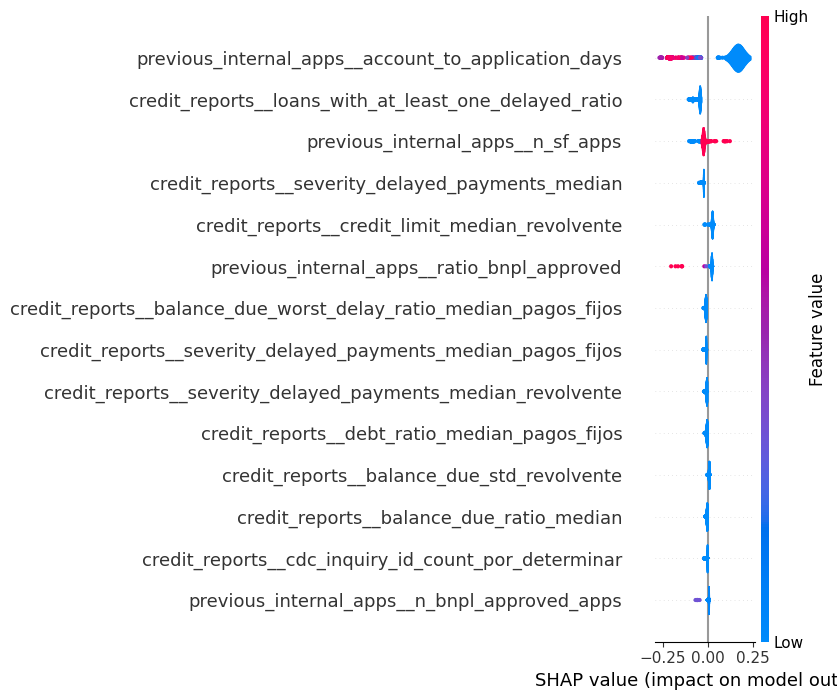

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.165105
10,credit_reports__loans_with_at_least_one_delaye...,0.053065
2,previous_internal_apps__n_sf_apps,0.033290
11,credit_reports__severity_delayed_payments_median,0.026279
8,credit_reports__credit_limit_median_revolvente,0.023692
3,previous_internal_apps__ratio_bnpl_approved,0.020876
6,credit_reports__balance_due_worst_delay_ratio_...,0.012451
12,credit_reports__severity_delayed_payments_medi...,0.011975
13,credit_reports__severity_delayed_payments_medi...,0.007692
9,credit_reports__debt_ratio_median_pagos_fijos,0.006912


In [17]:
df_test_filter = test_df[test_df["credit_reports__loans_count"]==0]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    

#### Shap Values - credit_reports__loans_count equal to 0

(1238, 14)


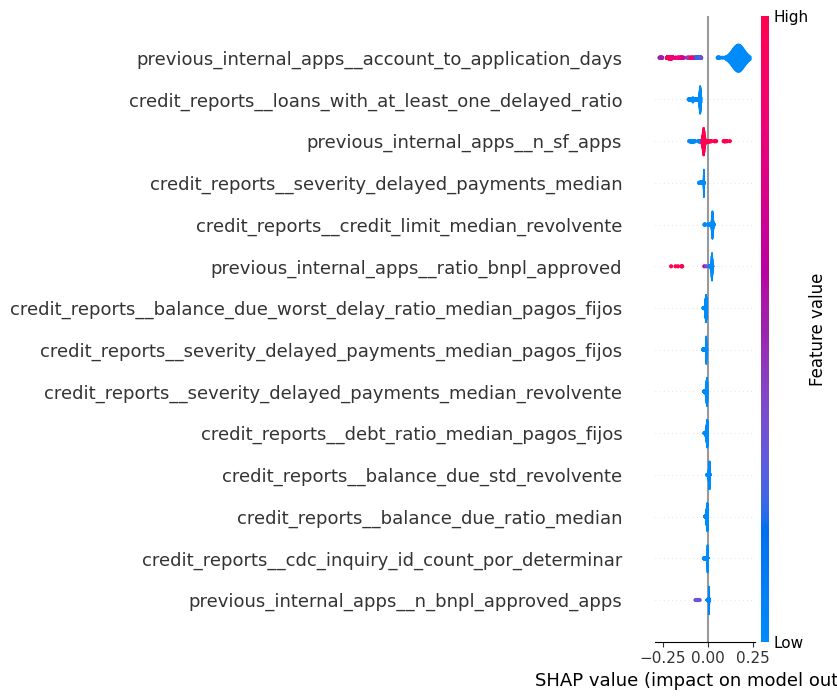

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.165105
10,credit_reports__loans_with_at_least_one_delaye...,0.053065
2,previous_internal_apps__n_sf_apps,0.033290
11,credit_reports__severity_delayed_payments_median,0.026279
8,credit_reports__credit_limit_median_revolvente,0.023692
3,previous_internal_apps__ratio_bnpl_approved,0.020876
6,credit_reports__balance_due_worst_delay_ratio_...,0.012451
12,credit_reports__severity_delayed_payments_medi...,0.011975
13,credit_reports__severity_delayed_payments_medi...,0.007692
9,credit_reports__debt_ratio_median_pagos_fijos,0.006912


In [18]:
df_test_filter = test_df[(test_df["credit_reports__loans_count"]==0)]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')
#shap.summary_plot(shap_values[1], X_test[features1], plot_type='bar')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    


(268, 14)


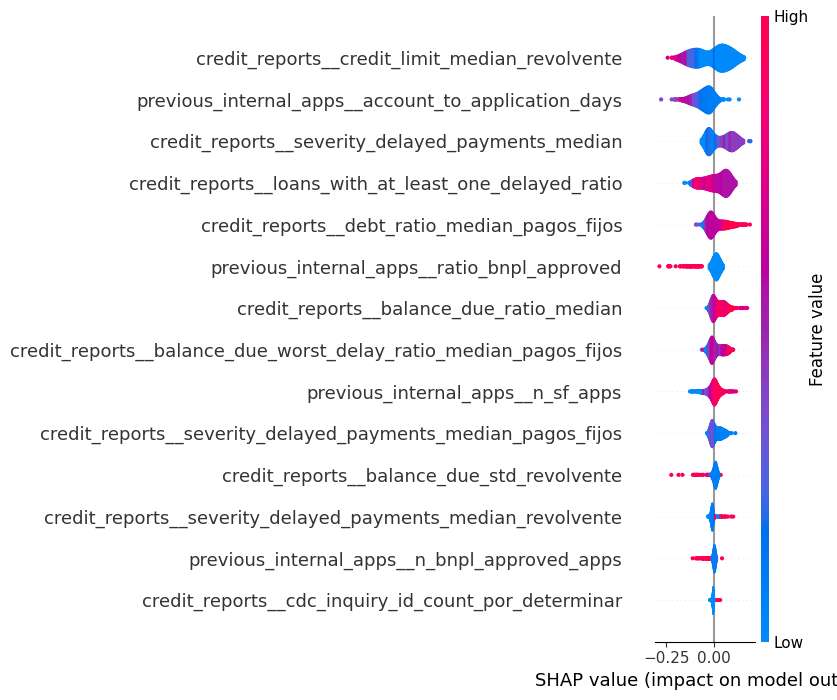

,col_name,shap_value
8,credit_reports__credit_limit_median_revolvente,0.080043
0,previous_internal_apps__account_to_application...,0.063448
11,credit_reports__severity_delayed_payments_median,0.060577
10,credit_reports__loans_with_at_least_one_delaye...,0.055878
9,credit_reports__debt_ratio_median_pagos_fijos,0.043509
3,previous_internal_apps__ratio_bnpl_approved,0.036898
4,credit_reports__balance_due_ratio_median,0.036016
6,credit_reports__balance_due_worst_delay_ratio_...,0.030255
2,previous_internal_apps__n_sf_apps,0.027178
12,credit_reports__severity_delayed_payments_medi...,0.024863


In [19]:
df_test_filter = test_df[(test_df["credit_reports__loans_count"]>0) & (test_df["credit_reports__loans_count"]<=5)]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')
#shap.summary_plot(shap_values[1], X_test[features1], plot_type='bar')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    

(2339, 14)


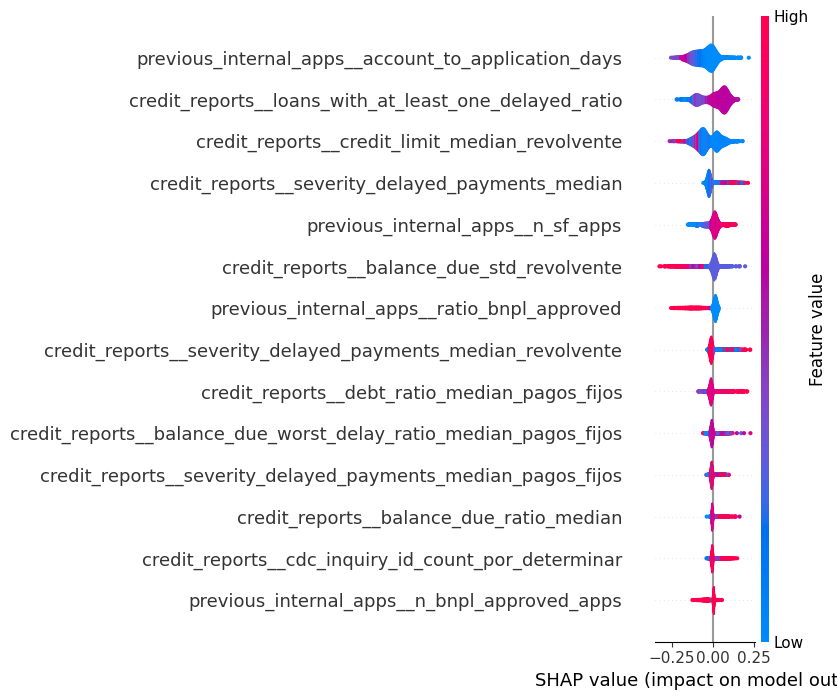

,col_name,shap_value
0,previous_internal_apps__account_to_application...,0.067438
10,credit_reports__loans_with_at_least_one_delaye...,0.066632
8,credit_reports__credit_limit_median_revolvente,0.066013
11,credit_reports__severity_delayed_payments_median,0.038753
2,previous_internal_apps__n_sf_apps,0.038455
5,credit_reports__balance_due_std_revolvente,0.033370
3,previous_internal_apps__ratio_bnpl_approved,0.031789
13,credit_reports__severity_delayed_payments_medi...,0.024447
9,credit_reports__debt_ratio_median_pagos_fijos,0.024392
6,credit_reports__balance_due_worst_delay_ratio_...,0.017540


In [20]:
df_test_filter = test_df[(test_df["credit_reports__loans_count"]>5)]
print(df_test_filter[features].shape)
shap_values = shap.TreeExplainer(model).shap_values(df_test_filter[features])
shap.summary_plot(shap_values, df_test_filter[features], plot_type='violin')
#shap.summary_plot(shap_values[1], X_test[features1], plot_type='bar')

feature_names = df_test_filter[features].columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','shap_value'])
shap_importance.sort_values(by=['shap_value'],
                               ascending=False, inplace=True)
shap_importance.head(60)
    